## Training Notebook 

### The following cell is a way to get the utility script required for this notebook. 
Since IBM CPD SaaS doesn't have a filesystem, this is the only reliable way to get scripts on the cloud environment.

```
!rm -rf MLOps-CPD && git clone --quiet -b master https://github.com/IBM/MLOps-CPD.git
```

⚠️ Run the following cells only if you are executing on IBM CPD SaaS.

In [4]:
!rm -rf MLOps_CPD

In [5]:
!rm -rf MLOps-CPD

In [6]:
!rm -rf MLOps-CPD && git clone --quiet -b master https://github.com/iiias/MLOps-CPD.git

In [7]:
!mv MLOps-CPD MLOps_CPD

In [8]:
!pip install ibm_watson_machine_learning ibm_watson_studio_pipelines ibm_aigov_facts_client

In [9]:
from botocore.client import Config
from ibm_botocore.client import Config
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix,plot_roc_curve,f1_score,auc,roc_curve,accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from ibm_aigov_facts_client import AIGovFactsClient
from ibm_watson_studio_pipelines import WSPipelines
from ibm_watson_machine_learning import APIClient
import warnings
import os, types
import pandas as pd
import numpy as np
import ibm_boto3
import seaborn as sns
import json
import pickle
import matplotlib.pyplot as plt

from os.path import exists
if exists("utils/fs_utils.py") and exists("utils/catalog_utils.py"):
    from utils import fs_utils,catalog_utils
else:
    # If utils/fs_utils.py and utils/catalog_utils.py exist we assume that you are running on CPD SaaS
    # and will therefore import scripts from the freshly cloned repository
#    from MLOps_CPD.utils import fs_utils, catalog_utils
    pass

from MLOps_CPD.utils import fs_utils, catalog_utils

warnings.filterwarnings("ignore")

## Succeeding cell contains the credentials for MLOps COS
```
## PROJECT COS 
AUTH_ENDPOINT = "https://iam.cloud.ibm.com/oidc/token"
ENDPOINT_URL = "https://s3.private.us.cloud-object-storage.appdomain.cloud"
API_KEY_COS = "xxx"
BUCKET_PROJECT_COS = "mlops-donotdelete-pr-qxxcecxi1dtw94"

##MLOPS COS
ENDPOINT_URL_MLOPS = "https://s3.jp-tok.cloud-object-storage.appdomain.cloud"
API_KEY_MLOPS = "xxx"
CRN_MLOPS = "xxx"
BUCKET_MLOPS  = "mlops-asset"

##CATALOG
CATALOG_NAME = "MLOps-ns"
```

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
## Retrieve cos credentials from global pipeline parameters
import json
# Get json from environment and convert to string
project_cos_credentials = json.loads(os.getenv('project_cos_credentials'))
mlops_cos_credentials = json.loads(os.getenv('mlops_cos_credentials'))

## PROJECT COS 
AUTH_ENDPOINT = project_cos_credentials['AUTH_ENDPOINT']
ENDPOINT_URL = project_cos_credentials['ENDPOINT_URL']
API_KEY_COS = project_cos_credentials['API_KEY']
BUCKET_PROJECT_COS = project_cos_credentials['BUCKET']

## MLOPS COS
ENDPOINT_URL_MLOPS = mlops_cos_credentials['ENDPOINT_URL']
API_KEY_MLOPS = mlops_cos_credentials['API_KEY']
CRN_MLOPS = mlops_cos_credentials['CRN']
BUCKET_MLOPS  = mlops_cos_credentials['BUCKET']

## Pipeline Params

In [12]:
CLOUD_API_KEY = os.getenv("cloud_api_key")

filename = os.getenv("feature_pickle")

MODEL_NAME =os.getenv("model_name")
DEPLOYMENT_NAME =os.getenv("deployment_name")
CATALOG_NAME="mlops-ns"

project_id = os.environ['PROJECT_ID']
space_id = os.getenv("model_name")

In [13]:
MODEL_NAME = "creditrisk-model"
DEPLOYMENT_NAME = "creditrisk-deployment"
space_id = MODEL_NAME

## Utility Functions

In [14]:
def download_file_cos(local_file_name,key):
    cos = ibm_boto3.client(service_name='s3',
                           ibm_api_key_id=API_KEY_MLOPS,
                           ibm_service_instance_id=CRN_MLOPS,
                           ibm_auth_endpoint=AUTH_ENDPOINT,
                           config=Config(signature_version='oauth'),
                           endpoint_url=ENDPOINT_URL_MLOPS)
    try:
        res=cos.download_file(Bucket=BUCKET_MLOPS,Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')
        
def read_data_from_mlops_cos(key):
    def __iter__(self): return 0
    MLOPS_DATA_STORE_client = ibm_boto3.client(
        service_name='s3',
        ibm_api_key_id=API_KEY_MLOPS,
        ibm_service_instance_id=CRN_MLOPS,
        ibm_auth_endpoint=AUTH_ENDPOINT,
        config=Config(signature_version='oauth'),
        endpoint_url=ENDPOINT_URL_MLOPS)

    body = MLOPS_DATA_STORE_client.get_object(Bucket=BUCKET_MLOPS, Key=key)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    gcf_df = pd.read_csv(body)
    return gcf_df

def load_model(key, filename):
    download_file_cos(key,filename)
    with open (filename,"rb") as f:
        pipeline = pickle.load(f)
    return pipeline

def check_if_file_exists(filename):
    mlops_client = ibm_boto3.client(
        service_name='s3',
        ibm_api_key_id=API_KEY_MLOPS,
        ibm_service_instance_id=CRN_MLOPS,
        ibm_auth_endpoint=AUTH_ENDPOINT,
        config=Config(signature_version='oauth'),
        endpoint_url=ENDPOINT_URL_MLOPS)
    
    for key in mlops_client.list_objects(Bucket=BUCKET_MLOPS)['Contents']:
        files = key['Key']
        if files == filename:
            return True
    return False

def save_data_in_cos(dictionary,filename,key):
    """

    Save Data in IBM Cloud Object Storage

    """
    try:
        with open(filename+'.pkl', 'wb') as f:
            pickle.dump(dictionary, f)
        mlops_res = ibm_boto3.resource(
            service_name='s3',
            ibm_api_key_id=API_KEY_MLOPS,
            ibm_service_instance_id=CRN_MLOPS,
            ibm_auth_endpoint=AUTH_ENDPOINT,
            config=Config(signature_version='oauth'),
            endpoint_url=ENDPOINT_URL_MLOPS)

        mlops_res.Bucket(BUCKET_MLOPS).upload_file(filename+'.pkl',key+'.pkl')
        print(f"File {filename} uploaded successfully")
    except Exception as e:
        print(e)
        print("File upload for {filename} failed")


In [15]:
# The code was removed by Watson Studio for sharing.

## Load the Saved Transformer from IBM COS 

In [16]:
pipeline = load_model(filename, filename)

File Downloaded


## Instantiate FactSheets Client

In [17]:
facts_client = AIGovFactsClient(api_key=CLOUD_API_KEY, experiment_name="CreditRiskModel", container_type="project", container_id=project_id, set_as_current_experiment=True)

2023/05/17 11:40:05 INFO : Experiment CreditRiskModel does not exist, creating new experiment
2023/05/17 11:40:06 INFO : Experiment successfully created with ID 1 and name CreditRiskModel
2023/05/17 11:40:06 INFO : Autolog enabled Successfully


## Load Train Data and Test Data 

In [18]:
train_data = read_data_from_mlops_cos('train_tfr.csv')
test_data = read_data_from_mlops_cos('test_tfr.csv')
train_data.head()

,LoanDuration,LoanAmount,InstallmentPercent,CurrentResidenceDuration,Age,ExistingCreditsCount,Dependents,Housing,Telephone,OthersOnLoan,Job,OwnsProperty,EmploymentDuration,LoanPurpose,CheckingStatus,CreditHistory,ExistingSavings,Sex,Risk
0,18,462,2,2,37,2,1,own,none,none,skilled,savings_insurance,1_to_4,car_new,less_0,credits_paid_to_date,less_100,female,0
1,15,250,2,3,28,2,1,own,yes,none,skilled,real_estate,1_to_4,furniture,less_0,prior_payments_delayed,less_100,male,0
2,28,6235,3,3,57,2,1,own,none,none,skilled,unknown,greater_7,education,no_checking,prior_payments_delayed,500_to_1000,male,1
3,9,1032,3,4,41,1,1,own,none,none,management_self-employed,savings_insurance,4_to_7,car_new,no_checking,prior_payments_delayed,100_to_500,male,0
4,11,4553,3,3,22,1,1,own,none,none,management_self-employed,savings_insurance,less_1,car_new,0_to_200,credits_paid_to_date,less_100,female,0


## Load train and test set

In [19]:
y_train = train_data['Risk']

y_test = test_data['Risk']


X_train = train_data.drop('Risk',axis=1)

X_test = test_data.drop('Risk',axis=1)


## Make validation set

In [20]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

## Instantiate a Classifier 

In [27]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier

model_lgb = LGBMClassifier(learning_rate=0.09,max_depth=5,random_state=42)

## Append the Pipeline

In [28]:
estimator_step = ['model_lgb',model_lgb]
pipeline.steps.append(estimator_step)
# if len(pipeline) >2:
#     pipeline= list(pipeline[0]).append(pipeline[-1])

In [26]:
pipeline.steps[0][1].fit(X_tr)

ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                 Index(['Housing', 'Telephone', 'OthersOnLoan', 'Job', 'OwnsProperty',
       'EmploymentDuration', 'LoanPurpose', 'CheckingStatus', 'CreditHistory',
       'ExistingSavings', 'Sex'],
      dtype='object')),
                                ('num', MinMaxScaler(),
                                 Index(['LoanDuration', 'LoanAmount', 'InstallmentPercent',
       'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount',
       'Dependents'],
      dtype='object'))])

## Baseline Model 

In [22]:
# model_pipeline = pipeline.fit(X_train,y_train)
model_pipeline = pipeline.fit(X_tr,y_tr,model_lgb__verbose=5, model_lgb__eval_set=[(pipeline.steps[0][1].transform(X_val), y_val),(pipeline.steps[0][1].transform(X_tr), y_tr)])

2023/05/17 07:50:56 INFO : logging results to factsheet for run_id 2995dfe3686144a79384859ed3993092
2023/05/17 07:50:56 INFO : logging results to factsheet for run_id 2995dfe3686144a79384859ed3993092
2023/05/17 07:50:58 INFO : Successfully logged results to Factsheet service for run_id 2995dfe3686144a79384859ed3993092 under asset_id: 024b6820-90e1-4cb8-8ed8-3edcd3022268 and project_id : 5f0d238e-b1b1-41c4-b83c-5a4c262d1988
2023/05/17 07:50:59 INFO : Successfully logged results to Factsheet service for run_id 2995dfe3686144a79384859ed3993092 under asset_id: 024b6820-90e1-4cb8-8ed8-3edcd3022268 and project_id : 5f0d238e-b1b1-41c4-b83c-5a4c262d1988
[5]	valid_0's binary_logloss: 0.539933	valid_1's binary_logloss: 0.516468
[10]	valid_0's binary_logloss: 0.495028	valid_1's binary_logloss: 0.45781
[15]	valid_0's binary_logloss: 0.47201	valid_1's binary_logloss: 0.422009
[20]	valid_0's binary_logloss: 0.460184	valid_1's binary_logloss: 0.397386
[25]	valid_0's binary_logloss: 0.452409	valid_1's

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

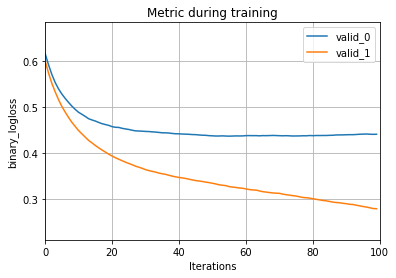

In [23]:
from lightgbm import plot_metric
plot_metric(pipeline.steps[1][1])

## Log the Train and Val loss

In [24]:
val_loss = pipeline.steps[1][1].evals_result_['valid_0']
train_loss = pipeline.steps[1][1].evals_result_['valid_1']

## Save train and val loss to COS

In [25]:
save_data_in_cos(val_loss,'val_loss','val_loss')
save_data_in_cos(train_loss,'train_loss','train_loss')

File val_loss uploaded successfully
File train_loss uploaded successfully


## Check if the files are copied in COS


In [26]:
files_copied_in_cos = check_if_file_exists('val_loss.pkl') and check_if_file_exists('val_loss.pkl')
files_copied_in_cos

True

## Baseline Results of the Model

In [27]:
predictions = pipeline.predict(X_test)

print(roc_auc_score(y_test,predictions))

0.7175182385975962


In [28]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = np.mean(cross_val_score(pipeline,X_train,y_train, cv=cv, n_jobs=-1,scoring='roc_auc'))
print(f"The Cross Validated AUC_ROC Score is {scores}")

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/mlflow/tracking/_tracking_service/utils.py:182: UserWarning: Failure attempting to register store for scheme "file": cannot import name 'MlflowClient' from partially initialized module 'mlflow.tracking' (most likely due to a circular import) (/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/mlflow/tracking/__init__.py)
  _tracking_store_registry.register_entrypoints()
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/mlflow/tracking/_tracking_service/utils.py:182: UserWarning: Failure attempting to register store for scheme "file": cannot import name 'MlflowClient' from partially initialized module 'mlflow.tracking' (most likely due to a circular import) (/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/mlflow/tracking/__init__.py)
  _tracking_store_registry.register_entrypoints()


The Cross Validated AUC_ROC Score is 0.8551584949484683


In [29]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(pipeline.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(pipeline.score(X_test, y_test)))

Training set score: 0.8658
Test set score: 0.7711


<AxesSubplot:>

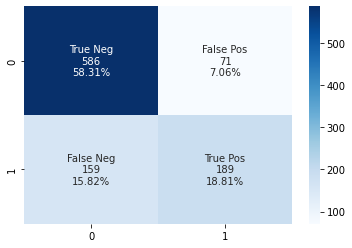

In [30]:
df_cm = confusion_matrix(y_test,predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2,v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')




Area Under Curve: 0.72




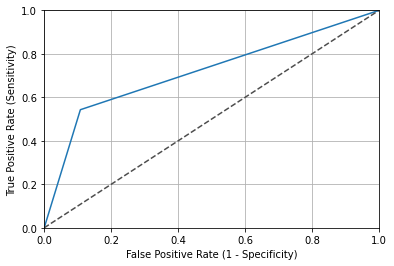

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("\n")
print ("Area Under Curve: %.2f" %auc(fpr, tpr))
print("\n")

## Store Model in the project

In [32]:
with open("model_pipeline.pkl",'wb') as f:
    pickle.dump(model_pipeline,f)

In [33]:
WML_CREDENTIALS = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey": CLOUD_API_KEY
            }

In [34]:
wml_client = APIClient(WML_CREDENTIALS)

## Save and Log Models in AI Factsheets.

In [37]:
def save_log_facts():
    ctutils = catalog_utils.CatalogUtils(
        service_url="https://api.dataplatform.cloud.ibm.com",
        api_key=CLOUD_API_KEY,
        project_id=project_id,
        auth_url="https://iam.cloud.ibm.com/identity/token")
    catalog_id = ctutils.get_catalog_id_map()[CATALOG_NAME]
    fsutils = fs_utils.FSUtils(wml_client=wml_client,catalog_id=catalog_id,project_id=project_id,bss_account_id='27ff418fedd6aedffb8dc6ae4164a1d2',space_id=space_id,facts_client=facts_client)
    train_ref  = fsutils.prepare_training_reference(apikey=CLOUD_API_KEY,crn=CRN_MLOPS,bucket_name=BUCKET_MLOPS,endpoint=ENDPOINT_URL_MLOPS,training_file_name="german_credit_risk.csv")
    model_id = fsutils.save_model(model=model_pipeline,model_name=MODEL_NAME,model_entry_name="MLOPs",model_entry_description="MLOps Model Entry",target="Risk",X=X_train,y=y_train,train_data_ref=train_ref, model_type="scikit-learn_1.1")
    
    nb_name = "train_models"
    nb_asset_id = "b8d38cab-e373-4303-bd09-12e1086c9132"
    CPD_URL ="https://dataplatform.cloud.ibm.com"

    nb_asset_url = "https://" + CPD_URL + "/analytics/notebooks/v2/" + nb_asset_id + "?projectid=" + project_id + "&context=cpdaas"

    latestRunId = facts_client.runs.list_runs_by_experiment('1').sort_values('start_time').iloc[-1]['run_id']
    facts_client.runs.set_tags(latestRunId, {"Notebook name": nb_name, "Notebook id": nb_asset_id, "Notebook URL" : nb_asset_url})
    facts_client.export_facts.export_payload(latestRunId)

    RUN_ID=facts_client.runs.get_current_run_id()
    facts_client.export_facts.export_payload(RUN_ID)
    
    return model_id


In [38]:
model_id = save_log_facts()

Creating connections...
SUCCESS
2023/05/17 07:53:50 INFO : Initiating logging to factsheet for run_id......2995dfe3686144a79384859ed3993092
2023/05/17 07:53:52 INFO : Successfully logged results to Factsheet service for run_id 2995dfe3686144a79384859ed3993092 under asset_id: ae65a666-2177-43c8-b444-3742de91b4df and project_id : 5f0d238e-b1b1-41c4-b83c-5a4c262d1988


----------------------------------------------------------------------------------------------
Successfully finished linking WML Model '504f1623-c06d-4f10-85c7-3d3c57dd6ac5' to Model Entry.
----------------------------------------------------------------------------------------------


2023/05/17 07:54:03 INFO : Initiating logging to factsheet for run_id......2995dfe3686144a79384859ed3993092
2023/05/17 07:54:04 INFO : Successfully logged results to Factsheet service for run_id 2995dfe3686144a79384859ed3993092 under asset_id: b393585d-293b-4f09-84e6-76b76cbff2f8 and project_id : 5f0d238e-b1b1-41c4-b83c-5a4c262d1988
2023/05/1

## Save Params in WS Pipeline

In [39]:
train_params = {}
train_params['auc_roc'] = float(auc(fpr, tpr))
train_params['training_done'] = True
train_params['model_name'] = MODEL_NAME
train_params['deployment_name'] = DEPLOYMENT_NAME
train_params['model_id'] = model_id
train_params['project_id'] = project_id
# train_params['model_pipeline'] = "/home/wsuser/work/model_pipeline.pkl"

pipelines_client = WSPipelines.from_apikey(apikey=CLOUD_API_KEY)
pipelines_client.store_results(train_params)

Running outside of Watson Studio Pipeline - storing results in the local filesystem for testing purposes...

  output paths:
    - "auc_roc": .ibm_watson_studio_pipelines/results/auc_roc
    - "training_done": .ibm_watson_studio_pipelines/results/training_done
    - "model_name": .ibm_watson_studio_pipelines/results/model_name
    - "deployment_name": .ibm_watson_studio_pipelines/results/deployment_name
    - "model_id": .ibm_watson_studio_pipelines/results/model_id
    - "project_id": .ibm_watson_studio_pipelines/results/project_id
